# Temporal Difference Learning (TD Learning)

## Windy gridworld

Based on [this](https://github.com/kkm24132/ReinforcementLearning/blob/main/04_TemporalDiff/WindyGridWorld.ipynb) notebook.

In [144]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt 
import seaborn as sns
import time

%matplotlib inline
sns.set_style("whitegrid")

### Defining an environment

In [145]:
class GridWorld(object):
    
    def __init__(self):
        super(GridWorld, self).__init__()
        self.start = 0
        self.goal = 0
        
        # Provide the setting of gridWorld rows and columns
        self.row = 7
        self.col = 10
        self.x_max = self.col - 1
        self.y_max = self.row - 1

        # Declare windy columns and their effect
        self.wind_1 = [3, 4, 5, 8]
        self.wind_2 = [6, 7]
        
        # Provide action list : Up/Down/Left/Right
        self.actions_list = ['N', 'E', 'S', 'W']
      
    # here, cells defined by index
    def cell(self,pos):
        return pos[1] + self.col * pos[0]
    
    def setTerminal(self, startState, goalState):
        # startState and goalState are tuples
        self.start = self.cell(startState)
        self.goal = self.cell(goalState)
        
    def nextState(self, state, action):
        # The "state" parameter is an integer that represents position in grid
        x = state % self.col
        y = (state - x) / self.col

        # Now let's define and interpret actions
        del_x = 0
        del_y = 0
        if action == 'E':
            del_x = 1
        elif action == 'W':
            del_x = -1
        elif action == 'N':
            del_y = -1
        elif action == 'S':
            del_y = 1
        else:
            raise('Invalid action! Actions taken must be in: ', self.actions_list)

        # Now move to new position
        new_x = max(0, min(x + del_x, self.x_max))
        new_y = max(0, min(y + del_y, self.y_max))
        
        # When wind blows to a new state
        if new_x in self.wind_1:
            new_y = max(0, new_y - 1)
        if new_x in self.wind_2:
            new_y = max(0, new_y - 2)
        
        # now let's return these new state values
        return self.cell((new_y,new_x))
    
    def checkTerminal(self, state):
        return state == self.goal
    
    def rewardFunction(self, state_prime):
        # When it reaches terminal state then reward is 0 else all actions should yield -1
        if self.checkTerminal(state_prime):
            return 0
        else:
            return -1

In [146]:
def trajectoryPath(world, traj):
    # Initialize gridworld
    world_map = np.zeros((world.row, world.col))
    for i,state in enumerate(traj):
        x = int(state % world.col)
        y = int((state - x) / world.col)
        world_map[y, x] = i + 1
    print(world_map)
    print("\n")

### SARSA

In [147]:
# function for greedy action
def greedyAct(_q_dict):
    greedy_act = ''
    max_q = -1e10
    for act in world.actions_list:
        if _q_dict[act] > max_q:
            greedy_act = act
            max_q = _q_dict[act]
    return greedy_act

# function for epsilon-greedy action
def epsGreedy(episode, q_dict, epsilon):
    
    m = len(world.actions_list)
    greedy_act = greedyAct(q_dict)

    # strange implementation; today you will see better ones
    p = []
    for act in world.actions_list:
        if act == greedy_act:
            p.append((epsilon * 1. / m) + 1 - epsilon)
        else:
            p.append(epsilon * 1. / m)

    # choose one action given proba
    choice = np.random.choice(world.actions_list, size = 1, p = p)
    return choice[0]

In [148]:
def gridWorld_SARSA(world, startState, goalState, alpha=0.1, gamma=1, epsilon=0.1):
    # Consider input parameters:
    # gamma = 1 as discounted factor
    # default values of alpha and epsilon considered, it will be changed for multiple analysis
    world.setTerminal(startState, goalState)
    
    # Initialize Q(s,a)
    q_table = {}
    for state in range(world.row * world.col):
        q_table[state] = {}
        for act in world.actions_list:
            q_table[state][act] = 0
    
    ep = 1 # Episode number
    ep_max = 300 # number of max episodes
    step_ep_list = []
    step = 0

    # strange implementation
    while ep < ep_max:

        # Initialize state
        state = world.cell(startState)
        trajectory = [state]
        
        # Choose action from state
        act = epsGreedy(ep, q_table[state], epsilon)

        # Processing action
        while not world.checkTerminal(state):
            state_prime = world.nextState(state, act)
            reward = world.rewardFunction(state_prime)
            act_prime = epsGreedy(ep, q_table[state_prime], epsilon)
            # what's wrong with it?
            q_table[state][act] += alpha * (reward + gamma * q_table[state_prime][act_prime] - q_table[state][act])
            state = state_prime
            act = act_prime

            # Increase Step Counter
            step += 1
            
            # Store the index of the episode of this time step
            step_ep_list.append(ep)
            
            # Update the trajectory
            trajectory.append(state)
        
        if ep == (ep_max - 1):
            trajectoryPath(world, trajectory)
        # Increase the episode counter
        ep += 1
    
    start_time = time.time()
    plt.plot(step_ep_list)
    print("Time elapsed is (in Secs): ", time.time() - start_time)
    plt.title('WindyGridWorld_SARSA ', fontsize = 'large')
    plt.xlabel("Number of Steps taken")
    plt.ylabel("Number of Episodes")
    plt.show()

#### SARSA experiments

Plot for Option: ∈=0.1, α=0.5 

[[ 0.  0.  0.  0. 10. 11. 12. 14. 15. 16.]
 [ 0.  0.  0.  9.  0.  0.  0.  0.  0. 19.]
 [ 6.  7.  8.  0.  0.  0.  0.  0.  0. 20.]
 [ 5.  0.  0.  0.  0.  0.  0. 26.  0. 21.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 22.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 25. 23.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 24.]]


Time elapsed is (in Secs):  0.017512798309326172


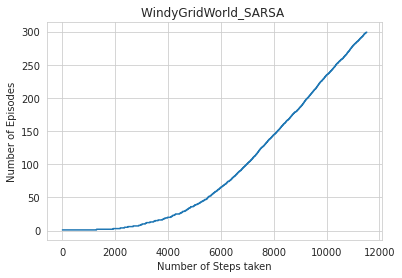

In [149]:
startState = (3, 0)
goalState = (3, 7)
world = GridWorld()
print("Plot for Option: ∈=0.1, α=0.5 \n")
gridWorld_SARSA(world, startState, goalState, alpha=0.5, epsilon=0.1)

Plot for Option: ∈=0.2, α=0.1 

[[ 0.  0.  0.  0.  0.  0. 16. 17. 18. 19.]
 [ 0.  0.  0.  0.  0.  0. 15.  0.  0. 20.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 21.]
 [ 1.  0.  0.  0.  0. 14.  0. 28.  0. 22.]
 [ 4.  0.  0.  0. 13.  0.  0.  0.  0. 23.]
 [ 7.  8.  0. 11.  0.  0.  0.  0. 27. 24.]
 [ 6.  9. 10.  0.  0.  0.  0.  0.  0. 26.]]


Time elapsed is (in Secs):  0.01740241050720215


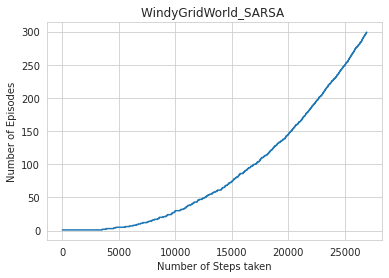

In [150]:
world = GridWorld()
print("Plot for Option: ∈=0.2, α=0.1 \n")
gridWorld_SARSA(world, startState, goalState, alpha=0.1, epsilon=0.2)

Plot for Option: ∈=0.05, α=0.2 

[[ 0.  0.  0.  0.  0.  6.  7.  8.  9. 10.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 11.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0. 12.]
 [ 1.  2.  3.  0.  0.  0.  0. 18.  0. 13.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 17. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 16.]]


Time elapsed is (in Secs):  0.01567673683166504


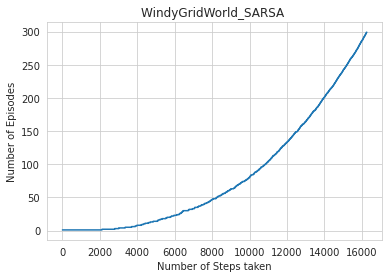

In [151]:
world = GridWorld()
print("Plot for Option: ∈=0.05, α=0.2 \n")
gridWorld_SARSA(world, startState, goalState, alpha=0.2, epsilon=0.05)

### Q-Learning

In [152]:
def gridWorld_QLearning(world, startState, goalState, alpha, gamma=1, ep_max=300, eps=0.1):
    world.setTerminal(startState, goalState) 
    # Initialize Q(s, a)
    q_dict = {}
    for state in range(world.row * world.col):
        q_dict[state] = {}
        for act in world.actions_list:
            if world.checkTerminal(state):
                q_dict[state][act] = 0
            else:
                q_dict[state][act] = np.random.rand()

    ep_wrt_step = []
    trajectory = []
    for ep in range(1, ep_max + 1):
        s = world.start
        trajectory = []
        while not world.checkTerminal(s):
            # Choose act according to behaviour policy
            act = epsGreedy(ep, q_dict[s], eps)
            # take act, observe s_prime & reward
            s_prime = world.nextState(s, act)
            reward = world.rewardFunction(s_prime)

            # choose act_prime according to target policy
            act_prime = greedyAct(q_dict[s_prime])
            # Update Q(s, a)
            q_dict[s][act] += alpha * (reward + gamma * q_dict[s_prime][act_prime] - q_dict[s][act])

            # store trajectory
            trajectory.append(s)

            # update current state
            s = s_prime
            # store the index of this episode for plot
            ep_wrt_step.append(ep)
        trajectory.append(world.goal)
    return trajectory, ep_wrt_step

#### Q-Learning experiments

Time elapsed:  0.5187163352966309
[[ 0.  0.  0.  0.  0.  7.  8.  9. 10. 11.]
 [ 0.  0.  0.  0.  6.  0.  0.  0.  0. 12.]
 [ 0.  0.  0.  5.  0.  0.  0.  0.  0. 13.]
 [ 2.  3.  4.  0.  0.  0.  0. 19.  0. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 18. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 17.]]




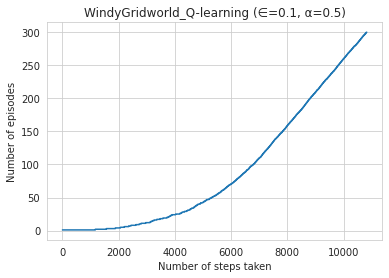

In [153]:
world = GridWorld()
start_time = time.time()
trajectory, ep_wrt_step = gridWorld_QLearning(world, startState, goalState, alpha=0.5,gamma=0.9,ep_max=300, eps=0.1)
print("Time elapsed: ", time.time() - start_time)
trajectoryPath(world, trajectory)
pl.figure(1)
pl.plot(ep_wrt_step)
plt.title('WindyGridworld_Q-learning (∈=0.1, α=0.5)', fontsize = 'large')
pl.xlabel("Number of steps taken")
pl.ylabel("Number of episodes")
pl.show()

Time elapsed:  1.7984185218811035
[[21. 18. 14. 13.  0. 52. 53. 55. 63. 64.]
 [22. 25. 10. 12.  0. 51.  0.  0. 62. 65.]
 [23. 26. 27.  4. 50.  0.  0.  0. 69. 70.]
 [ 1. 29. 28. 48.  0.  0.  0. 76.  0. 71.]
 [ 0. 30.  7.  0.  0.  0.  0.  0.  0. 72.]
 [41. 42.  0. 46.  0.  0.  0.  0. 75. 73.]
 [35. 43. 45.  0.  0.  0.  0.  0.  0. 74.]]




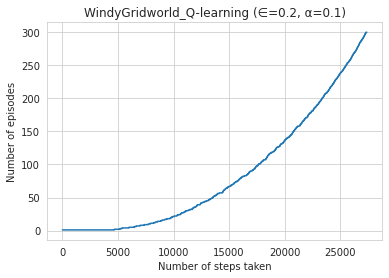

In [154]:
world = GridWorld()
start_time = time.time()
trajectory, ep_wrt_step = gridWorld_QLearning(world, startState, goalState, alpha=0.1,gamma=0.9,ep_max=300, eps=0.2)
print("Time elapsed: ", time.time() - start_time)
trajectoryPath(world, trajectory)
pl.figure(1)
pl.plot(ep_wrt_step)
plt.title('WindyGridworld_Q-learning (∈=0.2, α=0.1)', fontsize = 'large')
pl.xlabel("Number of steps taken")
pl.ylabel("Number of episodes")
pl.show()

Time elapsed:  1.1644320487976074
[[ 0.  0.  0.  0.  0.  6.  7.  8.  9. 10.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 13.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0. 14.]
 [ 1.  2.  3.  0.  0.  0.  0. 20.  0. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 19. 17.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 18.]]




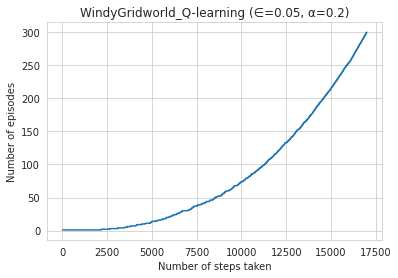

In [155]:
world = GridWorld()
start_time = time.time()
trajectory, ep_wrt_step = gridWorld_QLearning(world, startState, goalState, alpha=0.2,gamma=0.9,ep_max=300, eps=0.05)
print("Time elapsed: ", time.time() - start_time)
trajectoryPath(world, trajectory)
pl.figure(1)
pl.plot(ep_wrt_step)
plt.title('WindyGridworld_Q-learning (∈=0.05, α=0.2)', fontsize = 'large')
pl.xlabel("Number of steps taken")
pl.ylabel("Number of episodes")
pl.show()

## Gym Taxi

Based on [tutorial](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/).

### Environments in gym

In [156]:
!pip install cmake 'gym[atari]' 'gym[toy_text]' scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

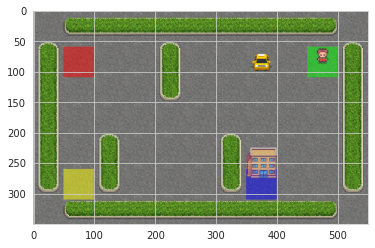

In [157]:
import gym

# making an environment
env = gym.make("Taxi-v3").env

env.reset()
prev_screen = env.render(mode='rgb_array')

plt.imshow(prev_screen)
plt.show()

In [158]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


State: 328


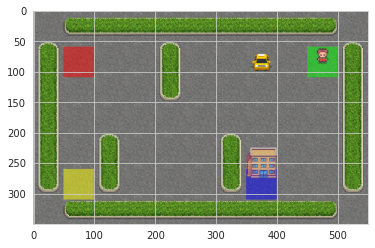

In [159]:
# setting taxi at (3, 1), pass. loc 2, destination loc. 0
state = env.encode(3, 1, 2, 0)
print("State:", state)

env.s = state
prev_screen = env.render(mode='rgb_array')

plt.imshow(prev_screen)
plt.show()

In [160]:
# reward table 

env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

`{action: [(probability, nextstate, reward, done)]}`

This environment is deterministic and fully observable. So, one may use MDP. Let us use Q-learning instead. 

### Q-learning

In [161]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [162]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1
        
        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.

CPU times: user 1min 30s, sys: 9.78 s, total: 1min 40s
Wall time: 1min 38s


In [163]:
q_table[328]

array([ -2.40933007,  -2.27325184,  -2.40271875,  -2.36097718,
       -10.95660299, -10.52296357])

Now let us evaluate and agent:

In [164]:
total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 13.17
Average penalties per episode: 0.0


## Mountain Car

In [165]:
import numpy as np # used for arrays
import gym # pull the environment
import time # to get the times

In [166]:
env = gym.make('MountainCar-v0')
env.reset()

array([-0.4986055,  0.       ], dtype=float32)

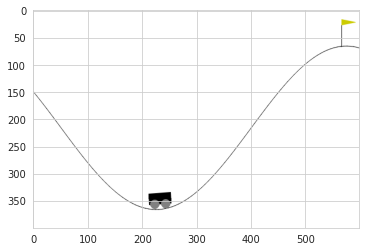

In [167]:
prev_screen = env.render(mode='rgb_array')

plt.imshow(prev_screen)
plt.show()

In [168]:
def QLearning(env, learning, discount, epsilon, min_eps, episodes):
    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    # Run Q learning algorithm
    for i in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
    
        while done != True:   
                
            # Determine next action - epsilon greedy strategy
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
                
            # Get next state and reward
            state2, reward, done, info = env.step(action) 
            
            # Discretize state2
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                
            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2_adj
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards
        reward_list.append(tot_reward)
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
            
    env.close()
    
    return ave_reward_list

In [169]:
# Run Q-learning algorithm
rewards = QLearning(env, 0.2, 0.9, 0.8, 0, 5000)

# Plot Rewards
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.savefig('rewards.jpg')     
plt.close()  


Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -200.0
Episode 400 Average Reward: -200.0
Episode 500 Average Reward: -200.0
Episode 600 Average Reward: -200.0
Episode 700 Average Reward: -200.0


KeyboardInterrupt: ignored

# Tasks

## Task 1

Change code in Mountain Car example, enhancing the implementation so that Average Reward is >-160 for at least last 1000 episodes, having 5000 epsiodes overall.

Describe what and why you have decided to change, explain your changes. 

**Graded up to 1 point.**

В данном случае интересно, что если машинка заезжает на гору, то ей даётся награда, но если она не доезжает в любом случае даётся -1, что крайне плохо. Возможным решением было изменить функцию начисления награды. Мы можем учитывать дальность машинки от цели и даже рассматривать ускорение.

Кроме того, получилось интересно, что при выключенном exploration такой агент работает лучше, поэтому я попробовал изменить epsilon до нуля, что позволило получить лучший average reward. (отдельный случай)

Большой exploration ведёт к плохим результатам.

In [170]:
import imageio

In [171]:
def MyQLearning(env, learning, discount, epsilon, min_eps, episodes):
    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes

    # Run Q learning algorithm
    for i in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = (state - env.observation_space.low) * np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)

        # make gifs
        frames = []

        while done != True:   
            
            # Determine next action - epsilon greedy strategy
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
                
            # Get next state and reward
            state2, reward, done, info = env.step(action)
            
            # Discretize state2
            state2_adj = (state2 - env.observation_space.low) * np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = 0 # reward
                
            # Adjust Q value for current state
            else:
                newreward = np.abs(state2[0] + 1.2) / 1.8 - 1 
                # delta = learning * (reward + 
                #                  discount * np.max(Q[state2_adj[0], 
                #                                    state2_adj[1]]) - 
                #                  Q[state_adj[0], state_adj[1], action])
                delta = learning * (newreward + 
                                 discount * np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1], action])
                Q[state_adj[0], state_adj[1], action] += delta

            # Update variables
            tot_reward += np.abs(state2[0] + 1.2) / 1.8 - 1 # reward
            state_adj = state2_adj
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards
        reward_list.append(tot_reward)
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))

        if frames and i > 5000 - 5 - 1:
            print(frames[-1].shape)
            imageio.mimsave(f'./nrew_{i+1}.gif', frames, fps=20)

    env.close()
    
    return ave_reward_list

In [ ]:
# Run Q-learning algorithm
rewards = MyQLearning(env=env, learning=0.2, discount=0.9, epsilon=0.8, min_eps=0, episodes=5000)

# Plot Rewards
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.savefig('rewards.jpg')
plt.close()

Episode 100 Average Reward: -124.47613788863849
Episode 200 Average Reward: -123.74560502895875


## Task 2

Record a `.gif` or `.mp4` file of the last five episodes for Mountain Car example.  

Also create a recording of the agent policy with exploration turned off.

**Graded up to 1 point.**

### GIF generation

In [ ]:
def MyQLearning(env, learning, discount, epsilon, min_eps, episodes):
    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes

    # # record gif
    # frames = []

    # Run Q learning algorithm
    for i in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = (state - env.observation_space.low) * np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)

        # get gif
        frames = []

        while done != True:   
            
            # Determine next action - epsilon greedy strategy
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
                
            # Get next state and reward
            state2, reward, done, info = env.step(action)

            if i > 5000 - 5 - 1:
                frames.append(env.render(mode="rgb_array"))
            
            # Discretize state2
            state2_adj = (state2 - env.observation_space.low) * np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = 0 # reward
                
            # Adjust Q value for current state
            else:
                # newreward = np.abs(state[0] + 1.2) / 1.8 - 1 
                delta = learning * (reward + 
                                 discount * np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1], action])
                # delta = learning * (newreward + 
                #                  discount * np.max(Q[state2_adj[0], 
                #                                    state2_adj[1]]) - 
                #                  Q[state_adj[0], state_adj[1], action])
                Q[state_adj[0], state_adj[1], action] += delta

            # Update variables
            tot_reward += reward # np.abs(state2[0] + 1.2) / 1.8 - 1 # reward
            state_adj = state2_adj
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards
        reward_list.append(tot_reward)
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))

        if frames and i > 5000 - 5 - 1:
            print(frames[-1].shape)
            imageio.mimsave(f'./{i+1}.gif', frames, fps=20)

    env.close()
    
    return ave_reward_list

In [ ]:
# Run Q-learning algorithm
rewards = MyQLearning(env=env, learning=0.2, discount=0.9, epsilon=0.01, min_eps=0, episodes=5000)

# Plot Rewards
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.savefig('rewards.jpg')
plt.close()

## Run with epsilon 0 (exploration off)

In [ ]:
# Run Q-learning algorithm
rewards = MyQLearning(env=env, learning=0.2, discount=0.9, epsilon=0.0, min_eps=0, episodes=5000)

# Plot Rewards
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.savefig('rewards.jpg')
plt.close()

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -199.84
Episode 300 Average Reward: -199.59
Episode 400 Average Reward: -199.95
Episode 500 Average Reward: -192.21
Episode 600 Average Reward: -193.81
Episode 700 Average Reward: -194.5
Episode 800 Average Reward: -189.94
Episode 900 Average Reward: -186.36
Episode 1000 Average Reward: -189.01
Episode 1100 Average Reward: -193.35
Episode 1200 Average Reward: -172.33
Episode 1300 Average Reward: -162.6
Episode 1400 Average Reward: -159.45
Episode 1500 Average Reward: -174.2
Episode 1600 Average Reward: -186.37
Episode 1700 Average Reward: -181.12
Episode 1800 Average Reward: -164.34
Episode 1900 Average Reward: -152.59
Episode 2000 Average Reward: -150.4
Episode 2100 Average Reward: -148.82
Episode 2200 Average Reward: -148.83
Episode 2300 Average Reward: -144.1
Episode 2400 Average Reward: -144.83
Episode 2500 Average Reward: -147.31
Episode 2600 Average Reward: -145.86
Episode 2700 Average Reward: -156.19
Episode 2800 Ave

/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
Episode 5000 Average Reward: -157.46
(400, 600, 3)
